## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Сульженко Родион Вадимович

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from train_utils import train
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

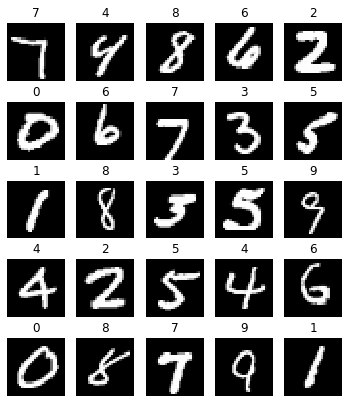

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [6]:
forward = []
backward = []

In [7]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    forward.append(std)
    #print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    backward.append(std)
    #print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [8]:
def make_linear(in_dim, out_dim, init_func):
    layer = nn.Linear(in_dim, out_dim)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_func(layer)
    
    return layer

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [9]:
def dumb_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=1)

def xavier_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    d = 2 / (weight.size()[0] + weight.size()[1])
    weight.normal_(mean=0, std=np.sqrt(d))
    
def xavier_init_uni(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    r = np.sqrt(6 / (weight.size()[0] + weight.size()[1]))
    weight.uniform_(-r, r)


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [10]:
def he_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    d = 2 / (weight.size()[0])
    weight.normal_(mean=0, std=np.sqrt(d))

In [11]:
import pandas as pd
stats = pd.DataFrame(columns=['forward disp', 'backward disp'])

def compare(init_f, activation_f, n_objects=100):
    
    net = []
    net.append(make_linear(28*28, 500, init_f))
    for i in range(8):
        net.append(make_linear(500, 500, init_f))
        net.append(activation_f())
    net.append(make_linear(500, 10, init_f))
    net = nn.Sequential(*net)

    X = images_train[:n_objects].view(n_objects, -1).data
    y = labels_train[:n_objects].data
    activations = net(X)
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
    loss = loss_fn(activations, y)
    loss.backward()
    stats['forward disp'] = forward
    stats['backward disp'] = backward
    print(stats)


In [12]:
forward, backward = [], []
compare(init_f=xavier_init_uni, activation_f=nn.ReLU)

   forward disp  backward disp
0      0.992241       0.028674
1      1.099245       0.014227
2      0.649740       0.008748
3      0.449515       0.005259
4      0.324414       0.003105
5      0.242841       0.001908
6      0.168775       0.001183
7      0.115888       0.000799
8      0.080738       0.000474
9      0.056928       0.000498


In [13]:
forward, backward = [], []
compare(init_f=xavier_init_uni, activation_f=nn.Tanh)

   forward disp  backward disp
0      0.992241       0.028674
1      1.100518       0.018521
2      0.650376       0.016601
3      0.500598       0.015180
4      0.424311       0.013511
5      0.369034       0.012046
6      0.333480       0.009825
7      0.306669       0.007517
8      0.280522       0.004305
9      0.265607       0.004194


In [14]:
forward, backward = [], []
compare(init_f=xavier_init_uni, activation_f=nn.ELU)

   forward disp  backward disp
0      0.992241       0.028674
1      1.102076       0.018399
2      0.828061       0.016361
3      0.676121       0.013331
4      0.564920       0.012129
5      0.492777       0.010690
6      0.440435       0.009492
7      0.390153       0.007353
8      0.340615       0.005503
9      0.301911       0.005477


In [15]:
forward, backward = [], []
compare(init_f=he_init, activation_f=nn.ReLU)

   forward disp  backward disp
0      0.992241       0.028674
1      1.769057       0.094221
2      1.468606       0.089922
3      1.442580       0.082255
4      1.450548       0.074458
5      1.384685       0.068404
6      1.384423       0.056355
7      1.410701       0.046661
8      1.439677       0.039367
9      1.299707       0.054193


In [16]:
forward, backward = [], []
compare(init_f=he_init, activation_f=nn.Tanh)

   forward disp  backward disp
0      0.992241       0.028674
1      1.745274       0.096694
2      0.829490       0.097816
3      0.670332       0.094320
4      0.615000       0.093239
5      0.589180       0.090038
6      0.576963       0.080667
7      0.568393       0.067306
8      0.562086       0.033863
9      0.563681       0.046752


In [17]:
forward, backward = [], []
compare(init_f=he_init, activation_f=nn.ELU)

   forward disp  backward disp
0      0.992241       0.028674
1      1.771394       0.099296
2      1.752789       0.099026
3      1.851930       0.103379
4      1.887015       0.101125
5      1.946993       0.102119
6      2.004841       0.105085
7      2.095873       0.106409
8      2.165355       0.106682
9      2.229293       0.164636


<i> 1.4 Сделайте выводы по первой части </i>

 -  Xavier лучше показывает себя с Tanh
 -  He лучше показывает себя с ReLU
 -  ELU показывает себя хуже всего
 

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [18]:
class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5, mean=0, std=0.01):
        super(DropConnect, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim).normal_(mean=mean, std=std), 
                                   requires_grad=True)
        self.bias = nn.Parameter(torch.Tensor(1, output_dim).zero_(), requires_grad=True)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.zeros(self.weight.size()) + (1 - self.p)
            mask = torch.bernoulli(mask)
        else:
            mask = torch.ones(self.weight.size()) * self.p
        mask = Variable(mask, requires_grad=False)
        output = torch.mm(x, self.weight*mask) + self.bias
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [19]:
from IPython.display import clear_output
def train(network, epochs, learning_rate, make_plot=True):
    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.size(0), -1)
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.size(0), -1)
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if make_plot == True:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train loss')
                plt.plot(test_loss_epochs, label='Test loss')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid()
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid()
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs

In [20]:
net = []

sizes = [28**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]):    
    net.append(nn.Linear(in_dim, out_dim))
    net.append(nn.Dropout(0.5))
    net.append(nn.ReLU())
    
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)

net

Sequential(
  (0): Linear(in_features=784, out_features=200, bias=True)
  (1): Dropout(p=0.5, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=200, out_features=200, bias=True)
  (4): Dropout(p=0.5, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=200, out_features=10, bias=True)
  (7): LogSoftmax()
)

In [21]:
%%time
# DropOut
tr_lss_do, tt_lss_do, tr_acc_do, tt_acc_do = train(net, epochs=20, 
                                                   learning_rate=0.001, make_plot=False)

Epoch 19... (Train/Test) NLL: 0.100/0.159	Accuracy: 0.969/0.955
CPU times: user 9min 21s, sys: 711 ms, total: 9min 22s
Wall time: 3min 41s


In [22]:
net = []

sizes = [28**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]):    
    net.append(DropConnect(in_dim, out_dim))
    net.append(nn.ReLU())
    
net.append(DropConnect(sizes[-1], 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)

net

Sequential(
  (0): DropConnect()
  (1): ReLU()
  (2): DropConnect()
  (3): ReLU()
  (4): DropConnect()
  (5): LogSoftmax()
)

In [23]:
%%time
# DropConnect
tr_lss_dc, tt_lss_dc, tr_acc_dc, tt_acc_dc = train(net, epochs=20, 
                                                   learning_rate=0.001, make_plot=False)

Epoch 19... (Train/Test) NLL: 0.080/0.117	Accuracy: 0.975/0.966
CPU times: user 10min 17s, sys: 905 ms, total: 10min 18s
Wall time: 4min 9s


In [24]:
net = []

sizes = [28**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]):    
    net.append(nn.Linear(in_dim, out_dim))
    net.append(nn.ReLU())
    
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)

net

Sequential(
  (0): Linear(in_features=784, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=200, bias=True)
  (3): ReLU()
  (4): Linear(in_features=200, out_features=10, bias=True)
  (5): LogSoftmax()
)

In [25]:
%%time
# Default
tr_lss_def, tt_lss_def, tr_acc_def, tt_acc_def = train(net, epochs=20, 
                                                       learning_rate=0.001, make_plot=False)

Epoch 19... (Train/Test) NLL: 0.010/0.113	Accuracy: 0.997/0.979
CPU times: user 9min 14s, sys: 809 ms, total: 9min 15s
Wall time: 3min 38s


<i> 2.3 Сделайте выводы по третьей части. Отобразите кривые обучения на одном графике </i>

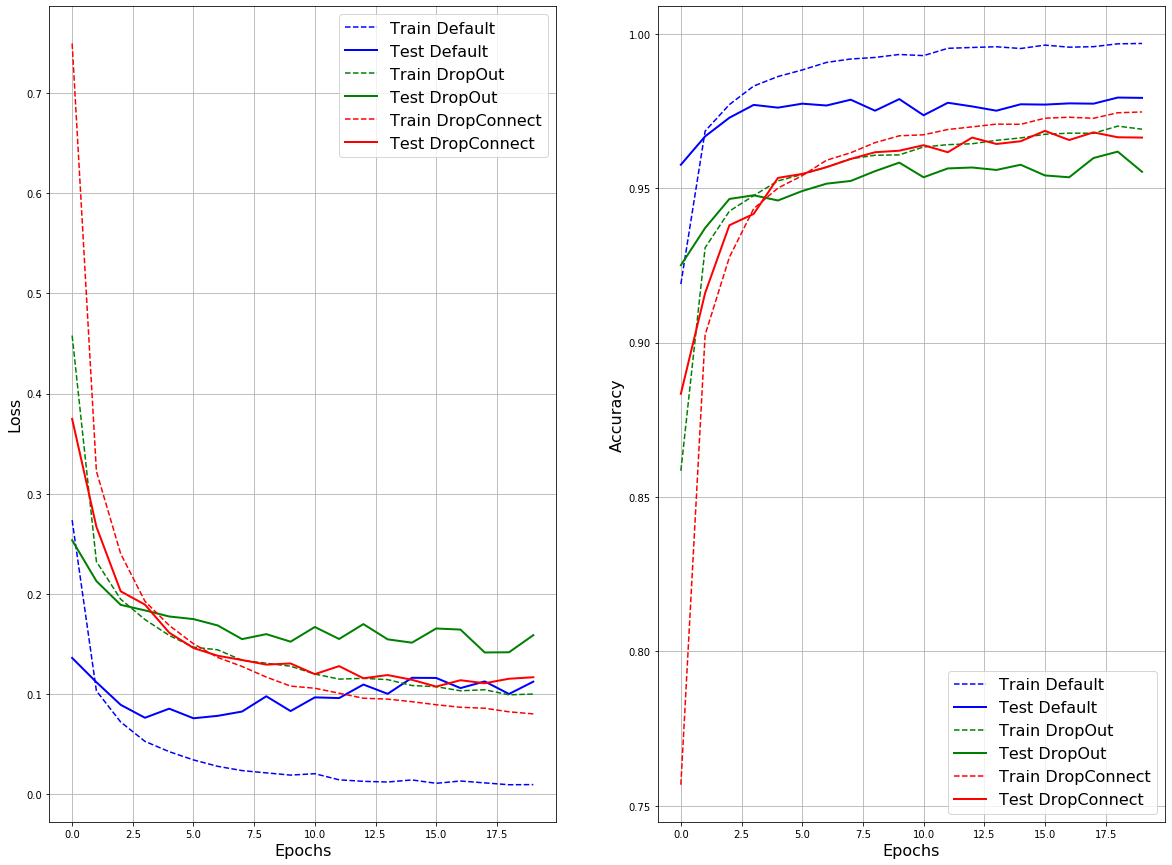

In [26]:
plt.figure(figsize=(20, 15))

plt.subplot(1, 2, 1)

plt.plot(tr_lss_def, linestyle='dashed', label='Train Default', color='blue')
plt.plot(tt_lss_def, label='Test Default', linewidth=2, color='blue')

plt.plot(tr_lss_do, linestyle='dashed', label='Train DropOut', color='green')
plt.plot(tt_lss_do, label='Test DropOut', linewidth=2, color='green')

plt.plot(tr_lss_dc, linestyle='dashed', label='Train DropConnect', color='red')
plt.plot(tt_lss_dc, label='Test DropConnect', linewidth=2, color='red')

plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)

plt.legend(loc='best', fontsize=16)
plt.grid('on')

plt.subplot(1, 2, 2)

plt.plot(tr_acc_def, linestyle='dashed', label='Train Default', color='blue')
plt.plot(tt_acc_def, label='Test Default', linewidth=2, color='blue')

plt.plot(tr_acc_do, linestyle='dashed', label='Train DropOut', color='green')
plt.plot(tt_acc_do, label='Test DropOut', linewidth=2, color='green')

plt.plot(tr_acc_dc, linestyle='dashed', label='Train DropConnect', color='red')
plt.plot(tt_acc_dc, label='Test DropConnect', linewidth=2, color='red')


plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)

plt.legend(loc='best', fontsize=16)
plt.grid('on')
plt.show()



 ##### Выводы:
 - DropConnect показал себя лучше, чем DropOut.
 - Однако без регуляризации результат лучше (возможно, плохо подобраны параметры)

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [27]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def forward(self, x):
        output = (x - x.mean(dim=1).view(-1, 1)) / x.std(dim=1).view(-1, 1)
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

In [28]:
net = nn.Sequential(nn.Linear(784, 200),
                    nn.BatchNorm1d(200, affine=False),
                    nn.ReLU(),
                    nn.Linear(200, 200),
                    nn.BatchNorm1d(200, affine=False),
                    nn.ReLU(),
                    nn.Linear(200, 10),
                    nn.LogSoftmax(1))
net

Sequential(
  (0): Linear(in_features=784, out_features=200, bias=True)
  (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=200, out_features=200, bias=True)
  (4): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=200, out_features=10, bias=True)
  (7): LogSoftmax()
)

In [29]:
%%time
tr_lss_bn, tt_lss_bn, tr_acc_bn, tt_acc_bn = train(net, epochs=20,
                                                   learning_rate=0.001, make_plot=False)

Epoch 19... (Train/Test) NLL: 0.006/0.078	Accuracy: 0.998/0.980
CPU times: user 10min 43s, sys: 907 ms, total: 10min 43s
Wall time: 4min 13s


In [30]:
net = nn.Sequential(nn.Linear(784, 200),
                    LayerNormalization(),
                    nn.ReLU(),
                    nn.Linear(200, 200),
                    LayerNormalization(),
                    nn.ReLU(),
                    nn.Linear(200, 10),
                    nn.LogSoftmax(1))
net

Sequential(
  (0): Linear(in_features=784, out_features=200, bias=True)
  (1): LayerNormalization()
  (2): ReLU()
  (3): Linear(in_features=200, out_features=200, bias=True)
  (4): LayerNormalization()
  (5): ReLU()
  (6): Linear(in_features=200, out_features=10, bias=True)
  (7): LogSoftmax()
)

In [31]:
%%time
tr_lss_ln, tt_lss_ln, tr_acc_ln, tt_acc_ln = train(net, epochs=20, 
                                                   learning_rate=0.001, make_plot=False)

Epoch 19... (Train/Test) NLL: 0.009/0.079	Accuracy: 0.997/0.981
CPU times: user 9min 43s, sys: 808 ms, total: 9min 44s
Wall time: 3min 49s


<i> 3.3 Сделайте выводы по третьей части </i>

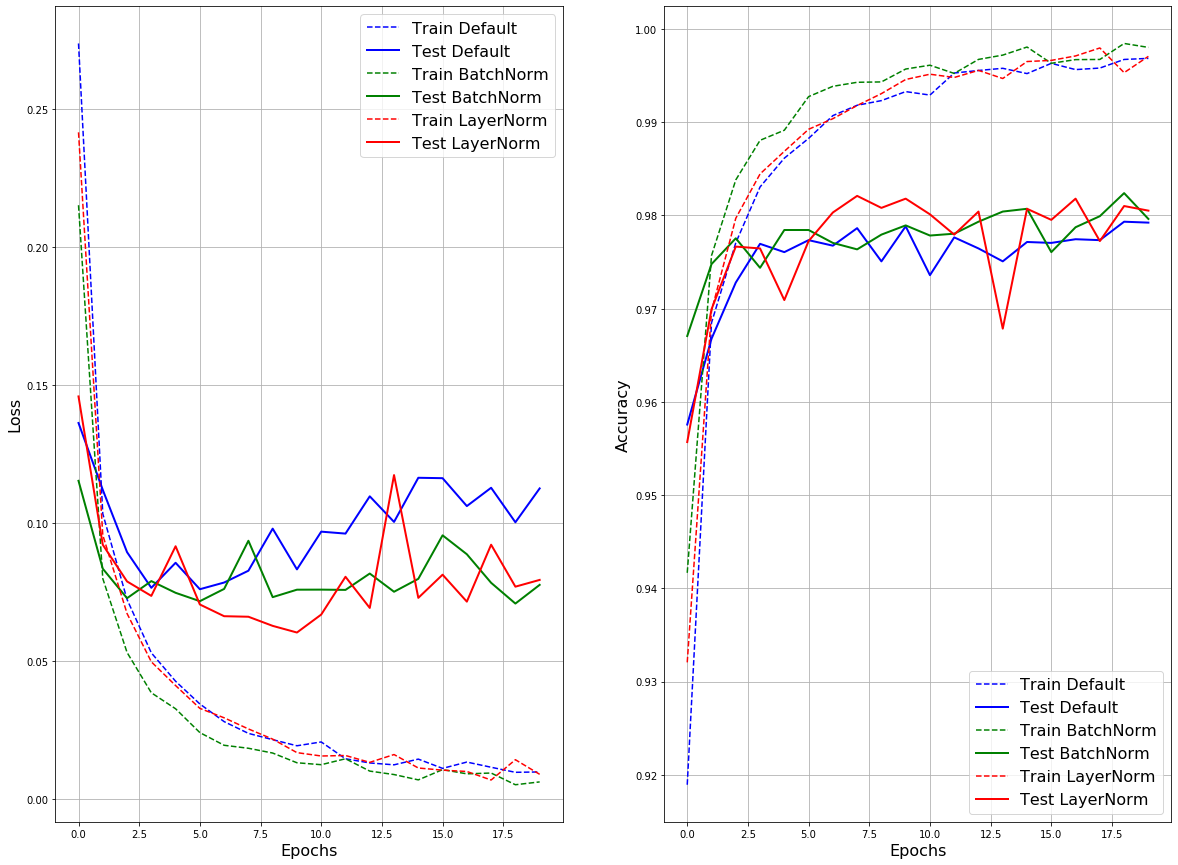

In [32]:
plt.figure(figsize=(20, 15))

plt.subplot(1, 2, 1)

plt.plot(tr_lss_def, linestyle='dashed', label='Train Default', color='blue')
plt.plot(tt_lss_def, label='Test Default', linewidth=2, color='blue')

plt.plot(tr_lss_bn, linestyle='dashed', label='Train BatchNorm', color='green')
plt.plot(tt_lss_bn, label='Test BatchNorm', linewidth=2, color='green')

plt.plot(tr_lss_ln, linestyle='dashed', label='Train LayerNorm', color='red')
plt.plot(tt_lss_ln, label='Test LayerNorm', linewidth=2, color='red')

plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)

plt.legend(loc=0, fontsize=16)
plt.grid('on')

plt.subplot(1, 2, 2)

plt.plot(tr_acc_def, linestyle='dashed', label='Train Default', color='blue')
plt.plot(tt_acc_def, label='Test Default', linewidth=2, color='blue')

plt.plot(tr_acc_bn, linestyle='dashed', label='Train BatchNorm', color='green')
plt.plot(tt_acc_bn, label='Test BatchNorm', linewidth=2, color='green')

plt.plot(tr_acc_ln, linestyle='dashed', label='Train LayerNorm', color='red')
plt.plot(tt_acc_ln, label='Test LayerNorm', linewidth=2, color='red')


plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)

plt.legend(loc='best', fontsize=16)
plt.grid('on')
plt.show()



###### Выводы:
 - Нормализация по слою в целом демонстрирует лучшие результаты
 - Однако в целом прирост незначительный (по крайней мере для данной архитектуры)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: